<a href="https://colab.research.google.com/github/LaisST/FIAP_202501_HandsOn_data_analytics/blob/main/TechChallenge_Fase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tech Challenge - Fase 2
## Predição do fechamento do IBOVESPA

## Objetivo


O objetivo desse modelo é prever se o IBOVESPA vai fechar maior ou menor do que o dia atual.

Com base nesse resultados será possível fazer analises internas que apoiarão as tomadas de decisões da empresa de fundos de investimentos.

Fonte de dados:  https://br.investing.com/indices/bovespa-historical-data

Amostra: 2 anos de dados com os fechamentos diarios do IBOVESPA

## Desenvolvimento do Modelos

### Importação das Bibliotecas

In [32]:
# Importar as bibliotecas
# Tratativa das bases
import numpy as np
import pandas as pd

#Visualização dos gráficos
import matplotlib.pyplot as plt
import seaborn as sns

#Preparação e treino do modelo
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

#Validação do modelo
from sklearn.metrics import accuracy_score


### Coleta e Carregamento dos Dados

In [2]:
# Importar a base de dados
df_ibovespa = pd.read_csv('/content/Dados Históricos - Ibovespa.csv', sep=',')
df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,12.09.2025,142.272,143.151,143.202,142.241,"6,39B","-0,61%"
1,11.09.2025,143.151,142.349,144.013,142.349,"7,57B","0,56%"
2,10.09.2025,142.349,141.612,143.182,141.612,"7,14B","0,52%"
3,09.09.2025,141.618,141.794,142.286,141.605,"7,48B","-0,12%"
4,08.09.2025,141.792,142.640,143.089,141.329,"7,44B","-0,59%"


### Pré-Processamento

#### Tipos de dados

In [3]:
# Análisar o tamanho da base
print(f'A base bruta contém {df_ibovespa.shape[0]} linhas e {df_ibovespa.shape[1]} colunas.')

A base bruta contém 499 linhas e 7 colunas.


In [4]:
# Analisar os tipos de dados das colunas
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      499 non-null    object 
 1   Último    499 non-null    float64
 2   Abertura  499 non-null    float64
 3   Máxima    499 non-null    float64
 4   Mínima    499 non-null    float64
 5   Vol.      499 non-null    object 
 6   Var%      499 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.4+ KB


In [5]:
# Converter a coluna Data para o tipo DateTime
df_ibovespa['Data'] = pd.to_datetime(df_ibovespa['Data'], dayfirst=True)

#Confirmar o tipo da coluna Data
print(df_ibovespa.dtypes)

Data        datetime64[ns]
Último             float64
Abertura           float64
Máxima             float64
Mínima             float64
Vol.                object
Var%                object
dtype: object


In [6]:
#Dividir o valor da coluna volume de forma que sejá possível converter para float
df_ibovespa['Unidade Volume'] = df_ibovespa['Vol.'].str[-1]
df_ibovespa['Volume'] = df_ibovespa['Vol.'].str[:-1]

#Substituir a , por .
df_ibovespa['Volume'] = df_ibovespa['Volume'].str.replace(',','.').astype(float)

df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B","-0,61%",B,6.39
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B","0,56%",B,7.57
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B","0,52%",B,7.14
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B","-0,12%",B,7.48
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B","-0,59%",B,7.44


In [7]:
# Multiplicar o vol pela unidade
fatores = {'K': 1000, 'M': 1000000, 'B': 1000000000}
df_ibovespa['Volume'] = df_ibovespa['Volume'] * df_ibovespa['Unidade Volume'].map(fatores)

df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B","-0,61%",B,6.390000e+09
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B","0,56%",B,7.570000e+09
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B","0,52%",B,7.140000e+09
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B","-0,12%",B,7.480000e+09
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B","-0,59%",B,7.440000e+09


In [8]:
# Corrigir a coluna Var%
# Remover o caracter %
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace('%', '', regex=False)

#Substituir a , por . e converter para float
df_ibovespa['Var%'] = df_ibovespa['Var%'].str.replace(',','.').astype(float)

#Transformar a coluna Var% que é % em decimal
df_ibovespa['Var%'] = df_ibovespa['Var%'] / 100

df_ibovespa.head(5)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B",-0.0061,B,6.390000e+09
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09


#### Qualidade dos dados

In [9]:
#Conferir se a base contém valores nulos
df_ibovespa.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0
Unidade Volume,0
Volume,0


In [10]:
#Conferir se a base contém valores duplicados
df_ibovespa.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0
Unidade Volume,0
Volume,0


#### Ordenar por Data

In [11]:
# Ordenar a tabela por data (mais antigo para o mais novo)
df_ibovespa = df_ibovespa.sort_values('Data')
df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
498,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07
497,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07
496,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07
495,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07
494,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06
...,...,...,...,...,...,...,...,...,...
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09


Podemos observar que a base não contém valores nulos ou duplicados.



#### Identificando Outliers

In [12]:
# Método IQR
Q1 = df_ibovespa['Último'].quantile(0.25)
Q3 = df_ibovespa['Último'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_ibovespa[(df_ibovespa['Último'] < limite_inferior) | (df_ibovespa['Último'] > limite_superior)]
outliers

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume
483,2023-10-05,113.284,113.609,114.359,112.705,"9,51M",-0.0028,M,9510000.0
473,2023-10-20,113.155,113.996,114.090,112.533,"11,74M",-0.0074,M,11740000.0
472,2023-10-23,112.785,113.145,113.680,112.164,"10,70M",-0.0033,M,10700000.0
470,2023-10-25,112.830,113.762,114.319,112.680,"12,31M",-0.0082,M,12310000.0
468,2023-10-27,113.301,114.777,115.342,112.953,"12,29M",-0.0129,M,12290000.0
467,2023-10-30,112.532,113.303,114.204,112.309,"9,74M",-0.0068,M,9740000.0
466,2023-10-31,113.144,112.534,113.597,112.098,"10,56M",0.0054,M,10560000.0


Observamos que, nesse caso, os Outliers não causam uma inconsistência relevante na análise dos dados.

#### Criando a coluna Target

In [13]:
# Identificar se o fechamento do dia seguinte é maior do que o fechamento do dia atual
df_ibovespa['Target'] = (df_ibovespa['Último'].shift(-1) > df_ibovespa['Último']).astype(int)
df_ibovespa.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Target
498,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,13280000.0,0
497,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,16110000.0,0
496,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,11270000.0,0
495,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,11450000.0,1
494,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9240000.0,0


In [14]:
#COnferindo o resultado do último dia da base, já que não há dia seguinte para identificar a Target
df_ibovespa.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Target
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,0
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,1
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,1
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,0
0,2025-09-12,142.272,143.151,143.202,142.241,"6,39B",-0.0061,B,6.390000e+09,0


### Análise Exploratória (EDA)

A análise exploratória permite entender o comportamento dos dados, identificar tendências e volatilidade, o que ajuda na escolha de features e melhores modelos para uma previsão mais assertiva.

In [15]:
# Análise estatística descretiva básica da base
df_ibovespa.describe()

,Data,Último,Abertura,Máxima,Mínima,Var%,Volume,Target
count,499,499.000000,499.000000,499.000000,499.000000,499.000000,4.990000e+02,499.000000
mean,2024-09-14 13:22:14.669338624,128.678721,128.630587,129.451208,127.898776,0.000412,3.333443e+09,0.507014
min,2023-09-14 00:00:00,112.532000,112.534000,113.597000,111.599000,-0.031500,4.330000e+06,0.000000
25%,2024-03-18 12:00:00,125.253000,125.192000,126.068500,124.489000,-0.004800,9.135000e+06,0.000000
50%,2024-09-12 00:00:00,128.228000,128.228000,129.178000,127.523000,0.000300,1.132000e+07,1.000000
75%,2025-03-17 12:00:00,133.150000,133.132000,134.048500,132.459500,0.005900,8.085000e+09,1.000000
max,2025-09-12 00:00:00,143.151000,143.151000,144.013000,142.349000,0.031200,2.487000e+10,1.000000
std,NaN,6.397648,6.385394,6.371014,6.387778,0.008966,4.820993e+09,0.500453


#### Distribuição dos dados

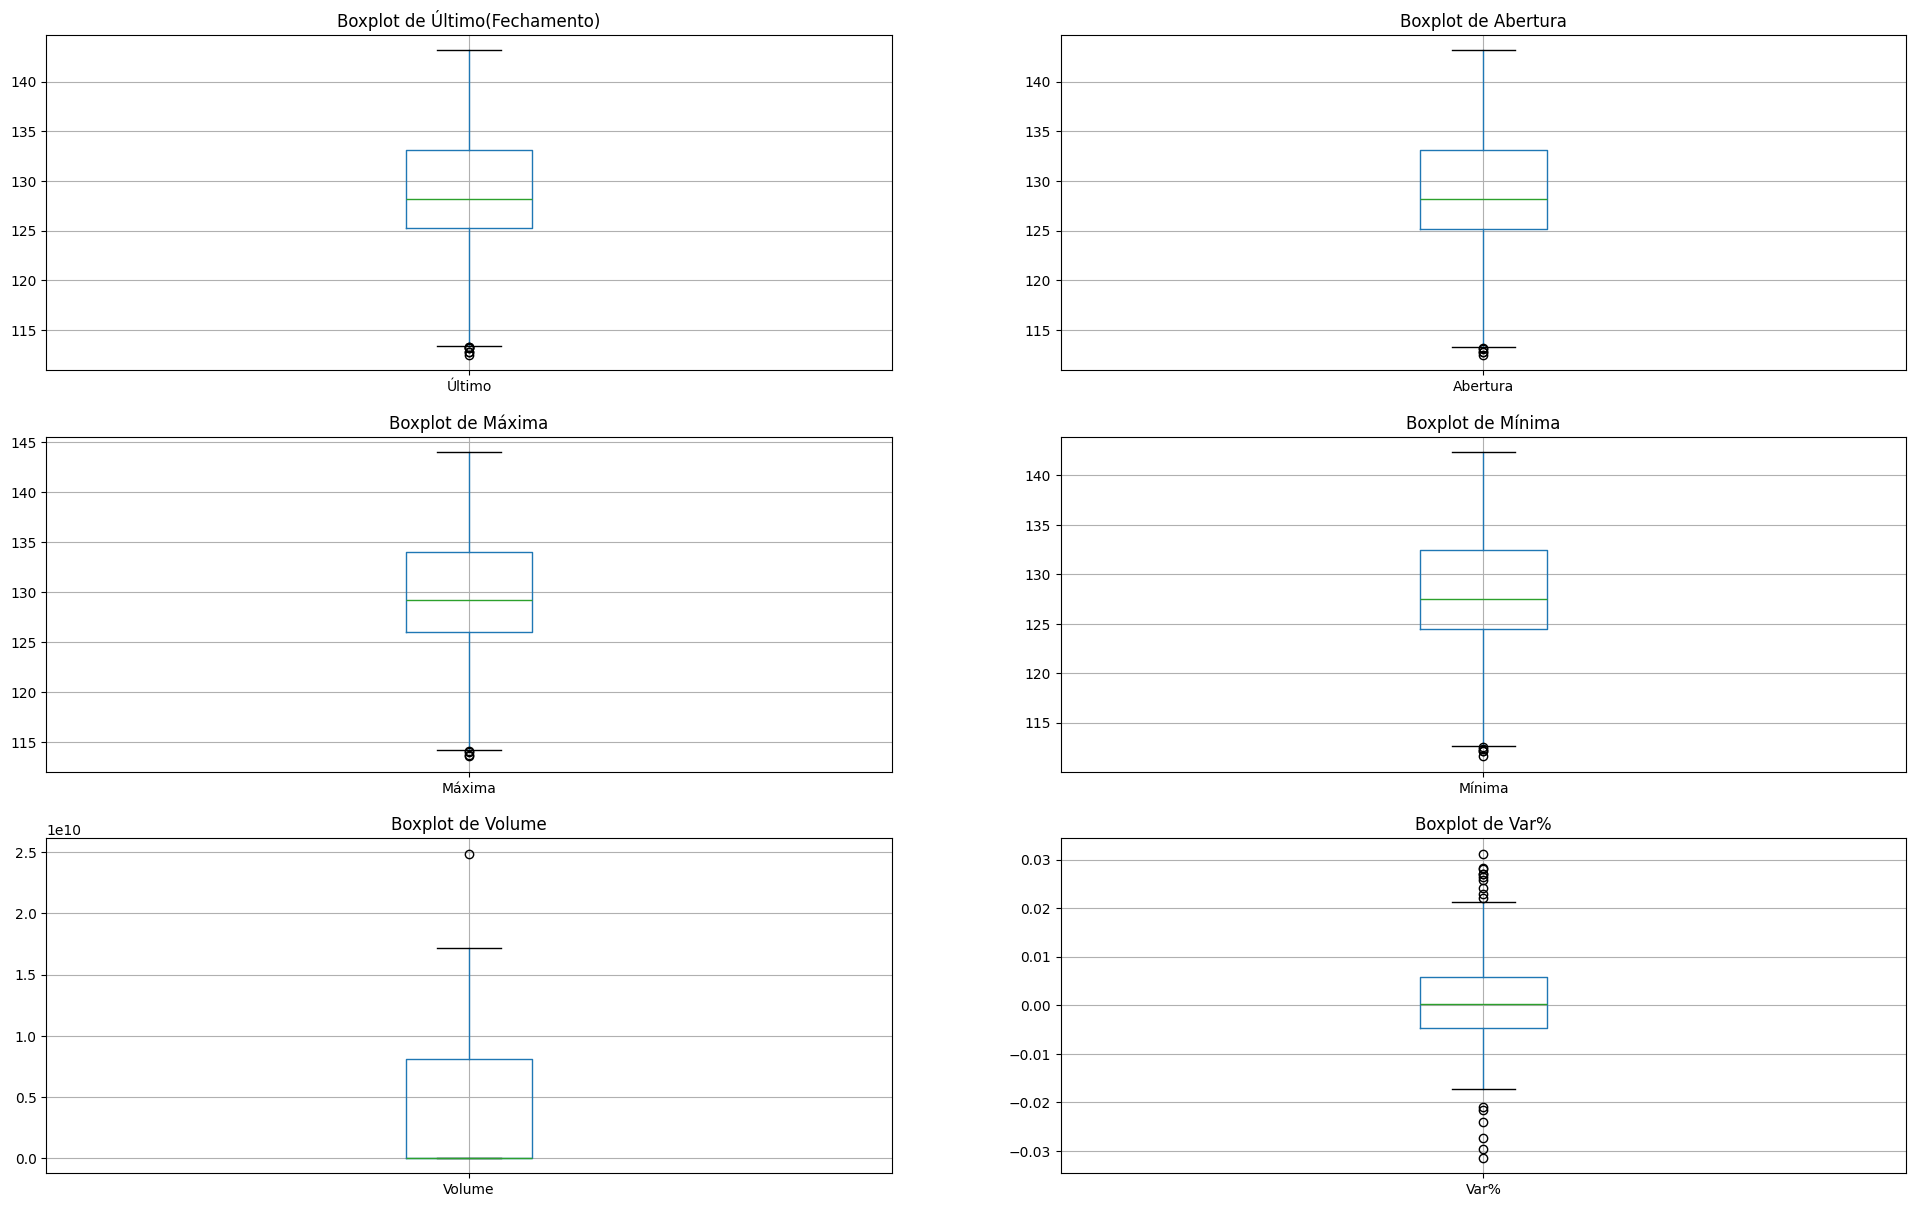

In [16]:
# Criar um gráfico com subplots para visualizar a distribuição dos dados de cada variavel
# ['Último', 'Abertura', 'Máxima', 'Mínima', 'Volume', 'Var%']
# Configurar o gráfico
plt.figure(figsize=(24,20))


plt.subplot(4,2,1)
fig = df_ibovespa.boxplot(column='Último')
fig.set_title('Boxplot de Último(Fechamento)')
fig.set_ylabel('')

plt.subplot(4,2,2)
fig = df_ibovespa.boxplot(column='Abertura')
fig.set_title('Boxplot de Abertura')
fig.set_ylabel('')

plt.subplot(4,2,3)
fig = df_ibovespa.boxplot(column='Máxima')
fig.set_title('Boxplot de Máxima')
fig.set_ylabel('')

plt.subplot(4,2,4)
fig = df_ibovespa.boxplot(column='Mínima')
fig.set_title('Boxplot de Mínima')
fig.set_ylabel('')

plt.subplot(4,2,5)
fig = df_ibovespa.boxplot(column='Volume')
fig.set_title('Boxplot de Volume')
fig.set_ylabel('')

plt.subplot(4,2,6)
fig = df_ibovespa.boxplot(column='Var%')
fig.set_title('Boxplot de Var%')
fig.set_ylabel('')

plt.show()

In [17]:
# Identificar os outliers na coluna VAR%
Q1 = df_ibovespa['Var%'].quantile(0.25)
Q3 = df_ibovespa['Var%'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers = df_ibovespa[(df_ibovespa['Var%'] < limite_inferior) | (df_ibovespa['Var%'] > limite_superior)]
outliers

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Target
493,2023-09-21,116.145,118.695,118.695,116.013,"12,69M",-0.0215,M,1.269000e+07,0
464,2023-11-03,118.160,115.062,118.502,115.062,"15,71M",0.0270,M,1.571000e+07,1
457,2023-11-14,123.166,120.411,123.370,120.411,"19,43M",0.0229,M,1.943000e+07,1
437,2023-12-13,129.465,126.406,129.793,126.299,"15,07M",0.0242,M,1.507000e+07,1
401,2024-02-06,130.416,127.593,130.417,127.593,"13,78M",0.0221,M,1.378000e+07,0
196,2024-11-28,124.610,127.667,127.668,124.390,"12,83M",-0.0240,M,1.283000e+07,1
186,2024-12-12,126.042,129.587,129.587,125.829,"13,45M",-0.0274,M,1.345000e+07,0
182,2024-12-18,120.772,124.699,124.699,120.457,"19,74M",-0.0315,M,1.974000e+07,1
166,2025-01-15,122.650,119.309,122.988,119.303,"11,93B",0.0281,B,1.193000e+10,0
155,2025-01-30,126.913,123.433,127.169,123.432,"11,69B",0.0282,B,1.169000e+10,0


Nesse caso, os outliers identificados na coluna de Variação é normal. A variação dos valores podem ocorrer devido eventos/situações no mercado financeiro.

#### Correlações

<Axes: >

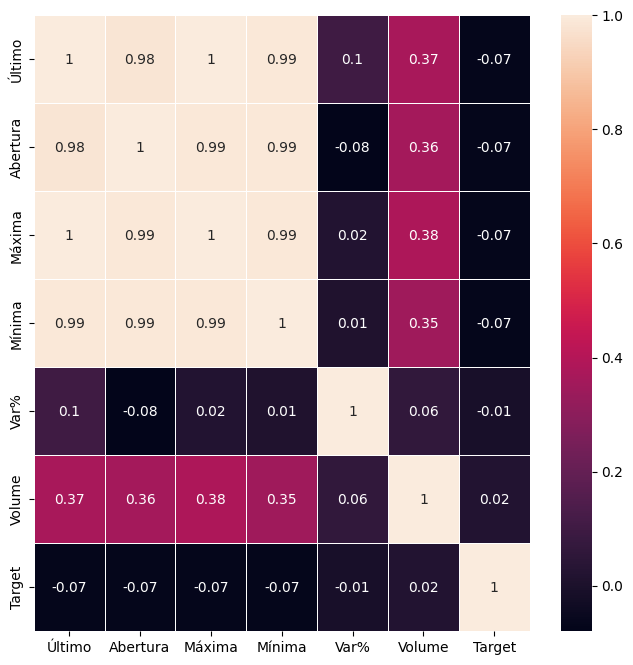

In [18]:
# Matriz de Correlação
correlation_matrix = df_ibovespa.corr(numeric_only=True).round(2)

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax = ax)

#### Tendências e Volatilidade

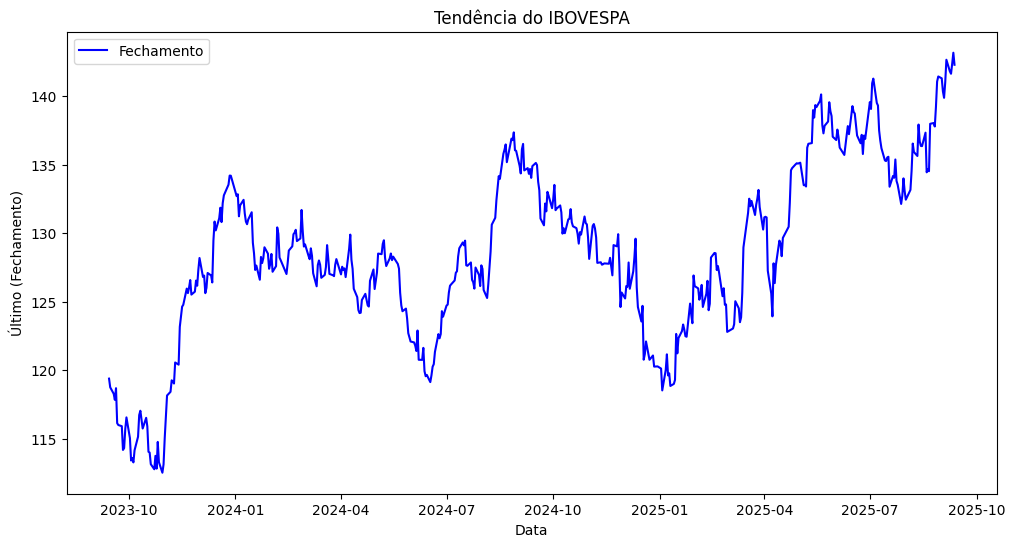

In [19]:
# Criar gráfico de tendencia
plt.figure(figsize=(12,6))
plt.plot(df_ibovespa['Data'], df_ibovespa['Último'], label='Fechamento', color='blue')
plt.title("Tendência do IBOVESPA")
plt.xlabel("Data")
plt.ylabel("Último (Fechamento)")
plt.legend()
plt.show()


Para facilitar a análise de tendências, comparei os anos de 2024 e 2025, observando o comportamento do fechamento mês a mês. O objetivo é identificar se há padrões sazonais que possam influenciar os resultados e apoiar previsões futuras.

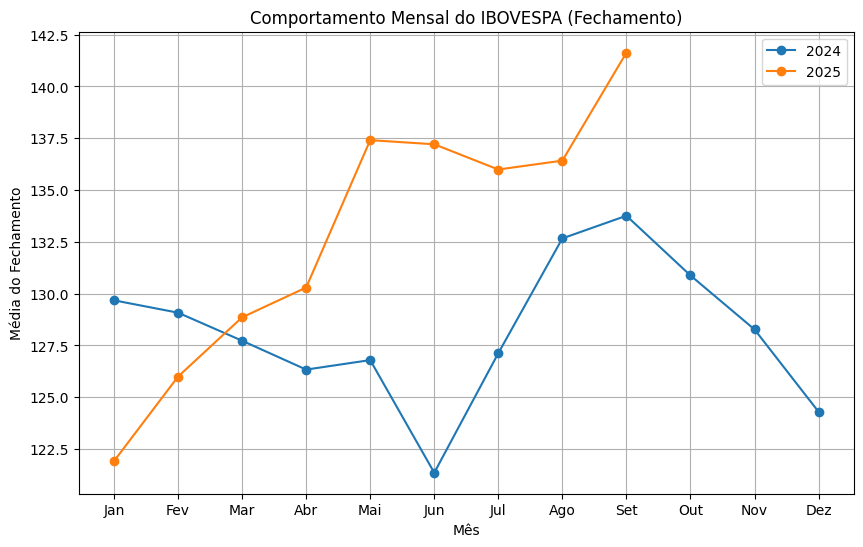

In [20]:
# Criar colunas de Ano e Mês
df_ibovespa['Ano'] = df_ibovespa['Data'].dt.year
df_ibovespa['Mes'] = df_ibovespa['Data'].dt.month

# Calcular a média de fechamento por mês e ano
df_mensal = df_ibovespa.groupby(['Ano','Mes'])['Último'].mean().reset_index()

# Separar 2024 e 2025
df_2024 = df_mensal[df_mensal['Ano'] == 2024]
df_2025 = df_mensal[df_mensal['Ano'] == 2025]

# Gráfico
plt.figure(figsize=(10,6))
plt.plot(df_2024['Mes'], df_2024['Último'], marker='o', label='2024')
plt.plot(df_2025['Mes'], df_2025['Último'], marker='o', label='2025')

plt.title("Comportamento Mensal do IBOVESPA (Fechamento)")
plt.xlabel("Mês")
plt.ylabel("Média do Fechamento")
plt.xticks(range(1,13), ['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez']) #Para facilitar a leitura
plt.legend()
plt.grid(True)
plt.show()



Conforme a análise, não foram identificados indícios claros de sazonalidade na amostra (2024 e 2025).

### Atributos
Identificação das features e target


In [21]:
#Criar features adicionais para melhorar o modelo
#Acompanhar o percentual de variação dos últimos fechamentos (3 e 5 dias)
# Retorno acumulado de X dias
df_ibovespa['Retorno_3dias'] = df_ibovespa['Último'].pct_change(periods=3)
df_ibovespa['Retorno_5dias'] = df_ibovespa['Último'].pct_change(periods=5)

df_ibovespa

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Target,Ano,Mes,Retorno_3dias,Retorno_5dias
498,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07,0,2023,9,NaN,NaN
497,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07,0,2023,9,NaN,NaN
496,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07,0,2023,9,NaN,NaN
495,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07,1,2023,9,-0.012949,NaN
494,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06,0,2023,9,-0.000530,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,0,2025,9,0.013785,0.003603
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,1,2025,9,0.004433,0.009142
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,1,2025,9,-0.002040,0.017767
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,0,2025,9,0.009584,0.015306


In [22]:
# Criar as médias móveis para suavizar ruídos do mercado. Com janela de 5 e 10 dias.

df_ibovespa['MediaMovel_5d'] = df_ibovespa['Último'].rolling(window=5).mean()
df_ibovespa['MediaMovel_10d'] = df_ibovespa['Último'].rolling(window=10).mean()


df_ibovespa


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Target,Ano,Mes,Retorno_3dias,Retorno_5dias,MediaMovel_5d,MediaMovel_10d
498,2023-09-14,119.392,118.181,119.748,118.181,"13,28M",0.0103,M,1.328000e+07,0,2023,9,NaN,NaN,NaN,NaN
497,2023-09-15,118.758,119.393,119.780,118.666,"16,11M",-0.0053,M,1.611000e+07,0,2023,9,NaN,NaN,NaN,NaN
496,2023-09-18,118.288,118.759,119.486,118.123,"11,27M",-0.0040,M,1.127000e+07,0,2023,9,NaN,NaN,NaN,NaN
495,2023-09-19,117.846,118.288,118.458,117.628,"11,45M",-0.0037,M,1.145000e+07,1,2023,9,-0.012949,NaN,NaN,NaN
494,2023-09-20,118.695,117.864,119.616,117.847,"9,24M",0.0072,M,9.240000e+06,0,2023,9,-0.000530,NaN,118.5958,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,0,2025,9,0.013785,0.003603,141.1248,140.6355
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,1,2025,9,0.004433,0.009142,141.3814,141.0202
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,1,2025,9,-0.002040,0.017767,141.8784,141.3345
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,0,2025,9,0.009584,0.015306,142.3100,141.5447


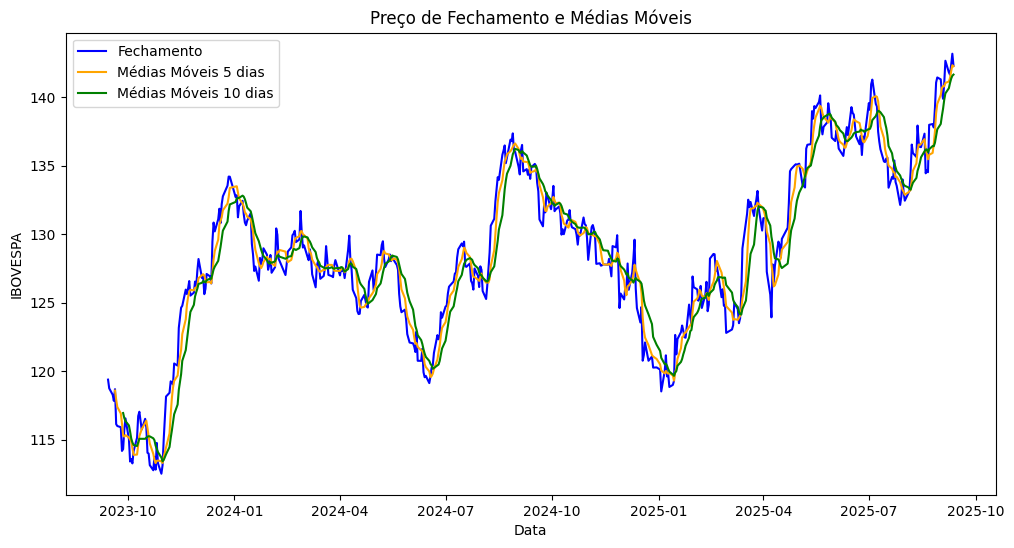

In [23]:
plt.figure(figsize=(12,6))
plt.plot(df_ibovespa['Data'], df_ibovespa['Último'], label='Fechamento', color='blue')
plt.plot(df_ibovespa['Data'], df_ibovespa['MediaMovel_5d'], label='Médias Móveis 5 dias', color='orange')
plt.plot(df_ibovespa['Data'], df_ibovespa['MediaMovel_10d'], label='Médias Móveis 10 dias', color='green')


plt.title('Preço de Fechamento e Médias Móveis')
plt.xlabel('Data')
plt.ylabel('IBOVESPA')
plt.legend()
plt.show()


As primeiras linhas nas features criadas, geraram resultados ***NaN***. Isso aconteceu porque a função não localizou linhas anteriores para fazer o calculo.
POr conta disso os valores NaN serão deletados da base para não interferir no modelo ML.

In [24]:
# Deletar as linhas com NaN nas novas features
df_ibovespa_tratado = df_ibovespa.dropna()
df_ibovespa_tratado

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Unidade Volume,Volume,Target,Ano,Mes,Retorno_3dias,Retorno_5dias,MediaMovel_5d,MediaMovel_10d
489,2023-09-27,114.327,114.193,115.340,113.366,"13,36M",0.0012,M,1.336000e+07,1,2023,9,-0.014499,-0.036800,115.3198,116.9578
488,2023-09-28,115.731,114.327,115.954,114.180,"10,39M",0.0123,M,1.039000e+07,1,2023,9,-0.001673,-0.003565,115.2370,116.5917
487,2023-09-29,116.565,115.742,116.899,115.742,"11,14M",0.0072,M,1.114000e+07,0,2023,9,0.020772,0.004793,115.3482,116.3724
486,2023-10-02,115.057,116.565,116.672,114.761,"8,52M",-0.0129,M,8.520000e+06,0,2023,10,0.006385,-0.007488,115.1746,116.0493
485,2023-10-03,113.419,115.055,115.056,113.151,"11,10M",-0.0142,M,1.110000e+07,1,2023,10,-0.019977,-0.006778,115.0198,115.6066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2025-09-08,141.792,142.640,143.089,141.329,"7,44B",-0.0059,B,7.440000e+09,0,2025,9,0.013785,0.003603,141.1248,140.6355
3,2025-09-09,141.618,141.794,142.286,141.605,"7,48B",-0.0012,B,7.480000e+09,1,2025,9,0.004433,0.009142,141.3814,141.0202
2,2025-09-10,142.349,141.612,143.182,141.612,"7,14B",0.0052,B,7.140000e+09,1,2025,9,-0.002040,0.017767,141.8784,141.3345
1,2025-09-11,143.151,142.349,144.013,142.349,"7,57B",0.0056,B,7.570000e+09,0,2025,9,0.009584,0.015306,142.3100,141.5447


### Divisão da Base de Dados

Definição das colunas x (Features) e y (Target)

Var%: Essa feature ajuda a entender o movimento do mercado.

Volume: Nssa feature podemos entender o interesse dos investidores.

Retorno_3dias e Retorno_5dias: Essas features acompanham a tendência de curto prazo, ampliando a visão além do dia anterior.

MediaMovel_5d e MediaMovel_10d: A lógica é que o modelo deve considerar a direção de longo prazo antes de tomar uma decisão de curto prazo.

In [26]:
# Definir as colunas que serão x e y
x = df_ibovespa_tratado[['Var%', 'Volume',  'Retorno_3dias', 'Retorno_5dias', 'MediaMovel_5d', 'MediaMovel_10d']]
y = df_ibovespa_tratado['Target']

In [27]:
# Separar a base para treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

### Modelos ML

#### Modelo Naive Bayes

Naive Bayes é um algoritmo de classificação probabilístico baseado no teorema de Bayes.

Ele assume que todas as variáveis preditoras são independentes entre si.

Essa simplificação torna o modelo extremamente rápido, eficiente e escalável.

In [28]:
# Treinar o modelo
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB()

In [29]:
# Predizendo valores
y_pred = gnb.predict(x_test)

##### Validando o Modelo Naive Bayes

In [31]:
# Identificar a acurácia do modelo Naive
accuracy = accuracy_score(y_test, y_pred)
print("A Acurácia do modelo Naive Bayes é ", round(accuracy,2))

A Acurácia do modelo Naive Bayes é  0.49


A Acuácia obtida no teste do modelo Naive Bayes foi de 49%.
O modelo não atingiu uma previsão muito assertiva.

Apesar das vantagens do modelo com a rapidez e simplicidade, a previsão do mercado financeiro requer uma abordagem mais complexa.

#### Modelo Random Forest Classifier

##### Validando modelo Random Forest Classifier  

 #### Modelo KNN Classifier

##### Validando o modelo KNN Classifier

### Conclusão